In [13]:
import sys
if '/home/ross/immunova' not in sys.path:
    sys.path.append('/home/ross/immunova')
from immunova.data.fcs_experiments import FCSExperiment
from immunova.flow.gating.actions import Gating
from immunova.flow.gating.transforms import apply_transform
from immunova.flow.gating.defaults import ChildPopulationCollection
from immunova.flow.gating.utilities import centroid, multi_centroid_calculation
from immunova.data.mongo_setup import test_init
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
from sklearn.neighbors import KDTree
from sklearn.cluster import DBSCAN, KMeans
from multiprocessing import Pool, cpu_count
from functools import partial
from itertools import cycle
from datetime import datetime
from matplotlib.patches import Rectangle, Ellipse
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
import pandas as pd
import numpy as np
import functools
import warnings
import os
warnings.filterwarnings('ignore')
test_init()

In [130]:
exp = FCSExperiment.objects(experiment_id='ILTIS_T1').get()

In [134]:
hc = Gating(exp, 'hc1')

Continuing with blank Gating object. Check that populations have not been removed.


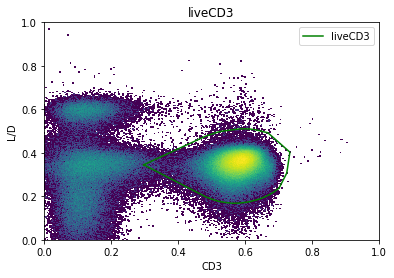

In [135]:
child_populations = ChildPopulationCollection('cluster')
child_populations.add_population('liveCD3', target=(0.6, 0.4), weight=1)
gate_definition = dict(x='CD3', y='L/D', min_pop_size=1000, frac=0.05)
hc.create_gate(gate_name='liveCD3', parent='lymphocytes', class_='DensityBasedClustering', 
                 method='hdbscan', kwargs=gate_definition, child_populations=child_populations)
hc.apply('liveCD3')

<h3>Guassian Mixture Model</h3>

In [20]:
hc.populations.keys()

dict_keys(['root', 'cells', 'debris', 'lymphocytes', 'other_cells', 'liveCD3'])

In [107]:
data = hc.get_population_df('liveCD3')

In [108]:
data.columns

Index(['FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W', 'CD57', 'CD161',
       'CD3', 'CCR7', 'L/D', 'Va7.2', 'CD8', 'Vd2', 'CD45RA', 'PanGD', 'CD4',
       'CD27', 'Time'],
      dtype='object')

In [109]:
features = ['CD57', 'CD161','CD3', 'CCR7', 
            'L/D', 'Va7.2', 'CD8', 'Vd2', 
            'CD45RA', 'PanGD', 'CD4', 'CD27']
td = apply_transform(data, features, 'logicle')
td = td[(td.PanGD <= 0.45) & (td.Vd2 <=0.5)]
td = td[(td['CD161'] <= 0.5) & (td['Va7.2'] <=0.55)]

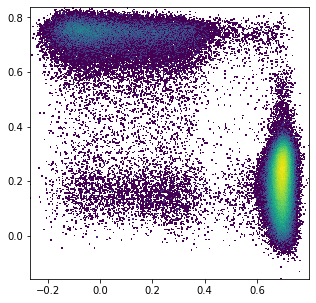

In [110]:
fig, ax = plt.subplots(figsize=(5,5))
ax.hist2d(td['CD4'], td['CD8'], bins=500, norm=LogNorm())
fig.show()

In [111]:
from sklearn import mixture
# fit a Gaussian Mixture Model with two components
model = mixture.GaussianMixture(n_components=2, covariance_type='full')
model.fit(td[['CD4', 'CD8']])

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=2, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

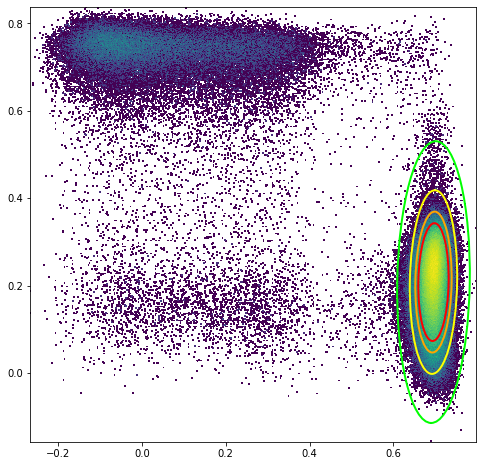

In [128]:
from scipy import stats, linalg
from itertools import cycle

fig, ax = plt.subplots(figsize=(8,8))
ax.hist2d(td['CD4'], td['CD8'], bins=500, norm=LogNorm())
i=1
eigen_val, eigen_vec = linalg.eigh(model.covariances_[i])
tp_medoid = tuple(model.means_[i])
conf_int = [0.8, 0.9, 0.98, 0.9999]
colours = ['red', 'orange', 'yellow', 'lime', 'violet']
for c, colour in zip(conf_int, colours):
    eigen_val, eigen_vec = linalg.eigh(model.covariances_[i])
    chi2 = stats.chi2.ppf(c, 2)
    eigen_val = 2. * np.sqrt(eigen_val) * np.sqrt(chi2)
    e = eigen_vec[0] / linalg.norm(eigen_vec[0])
    angle = 180. * np.arctan(e[1] / e[0]) / np.pi
    ax.add_patch(Ellipse(xy=tp_medoid, width=eigen_val[0], height=eigen_val[1], angle=(180.+angle),
                        alpha=1, color=colour, linewidth=2, fill=False))
fig.show()

In [59]:
model.means_[0]

array([0.69570881, 0.20802656])

<h3>DBSCAN</h3>

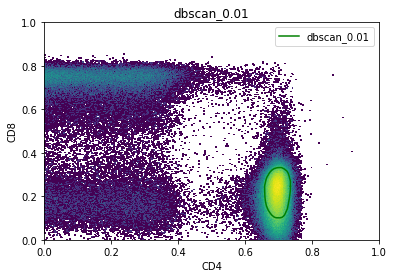

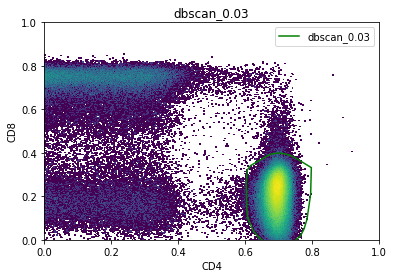

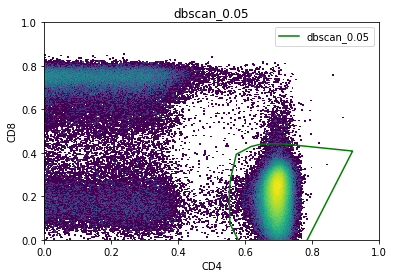

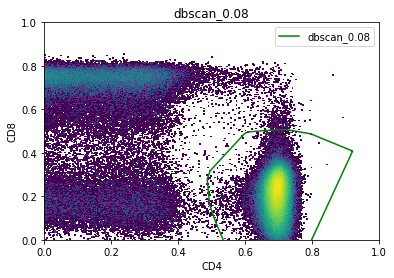

In [141]:
for x in [0.1, 0.15, 0.2]:
    child_populations = ChildPopulationCollection('cluster')
    child_populations.add_population(f'dbscan_{x}', target=(0.7, 0.2), weight=1)
    gate_definition = dict(x='CD4', y='CD8', min_pop_size=1000, distance_nn=x, frac=0.2)
    hc.create_gate(gate_name=f'dbscan_{x}', parent='liveCD3', class_='DensityBasedClustering', 
                     method='dbscan', kwargs=gate_definition, child_populations=child_populations)
    hc.apply(f'dbscan_{x}')

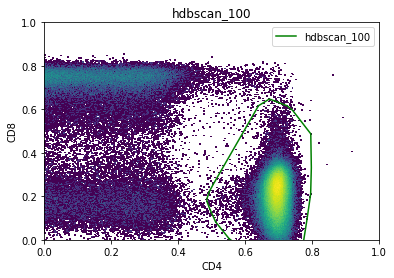

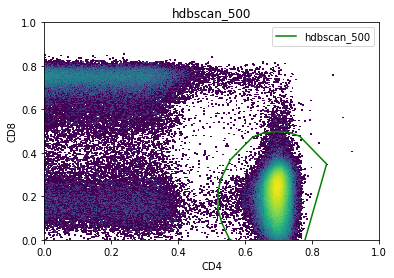

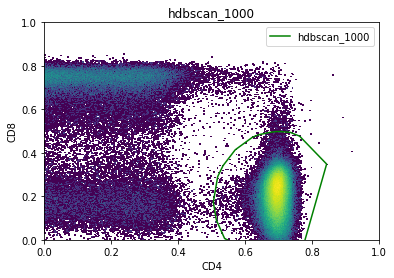

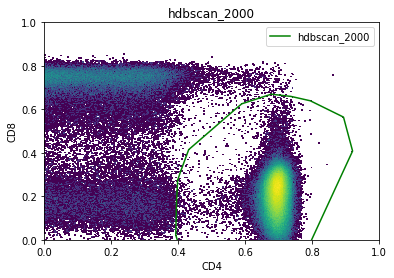

In [142]:
for x in [100, 500, 1000, 2000]:
    child_populations = ChildPopulationCollection('cluster')
    child_populations.add_population(f'hdbscan_{x}', target=(0.7, 0.2), weight=1)
    gate_definition = dict(x='CD4', y='CD8', min_pop_size=x, frac=0.2)
    hc.create_gate(gate_name=f'hdbscan_{x}', parent='liveCD3', class_='DensityBasedClustering', 
                     method='hdbscan', kwargs=gate_definition, child_populations=child_populations)
    hc.apply(f'hdbscan_{x}')

In [144]:
data = apply_transform(hc.get_population_df('liveCD3'), ['CD4', 'CD8'], 'logicle')

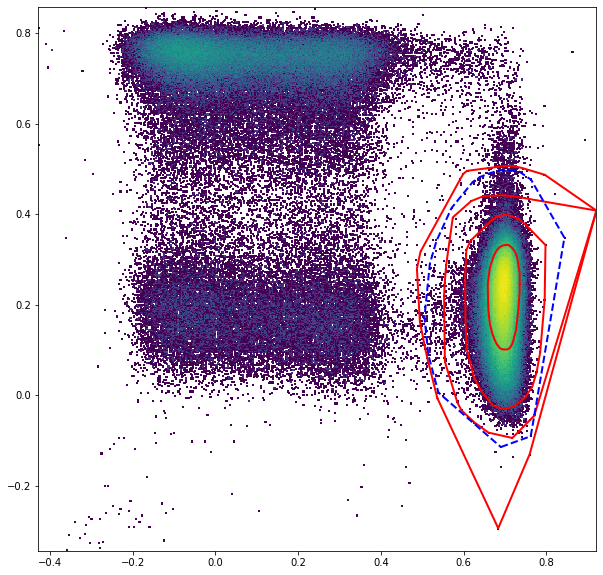

In [149]:
fig, ax = plt.subplots(figsize=(10,10))
ax.hist2d(data['CD4'], data['CD8'], bins=500, norm=LogNorm())

for x in [0.01, 0.03, 0.05, 0.08]:
    geom = hc.populations[f'dbscan_{x}'].geom
    x1 = geom['cords']['x']
    y1 = geom['cords']['y']
    ax.plot(x1, y1, '-k', c='r', linewidth=2)
geom = hc.populations[f'hdbscan_1000'].geom
x1 = geom['cords']['x']
y1 = geom['cords']['y']
ax.plot(x1, y1, '-k', c='b', linewidth=2, linestyle='--')
fig.show()

<h3>Density Threshold</h3>

In [174]:
data = hc.get_population_df('lymphocytes')
features = ['CD57', 'CD161','CD3', 'CCR7', 
            'L/D', 'Va7.2', 'CD8', 'Vd2', 
            'CD45RA', 'PanGD', 'CD4', 'CD27']
td = apply_transform(data, features, 'logicle')

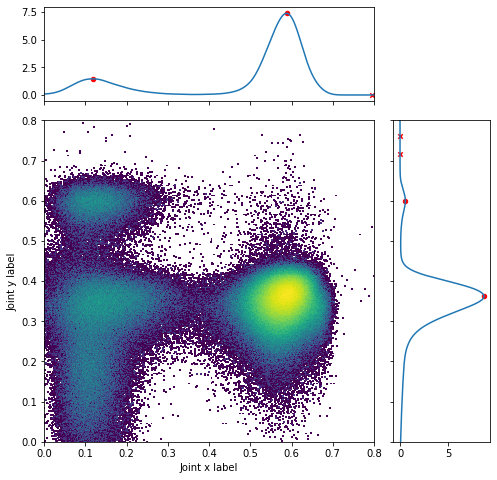

In [189]:
from matplotlib.gridspec import GridSpec
from immunova.flow.gating.utilities import kde, check_peak
from scipy.signal import find_peaks
from matplotlib import transforms
fig = plt.figure(figsize=(8,8))
gs = GridSpec(4,4)

ax_joint = fig.add_subplot(gs[1:4,0:3])
ax_marg_x = fig.add_subplot(gs[0,0:3])
ax_marg_y = fig.add_subplot(gs[1:4,3])

ax_joint.hist2d(td['CD3'], td['L/D'], bins=500, norm=LogNorm())

x_density, xx = kde(td.sample(frac=0.25), 'CD3', 0.01)
x_peaks = find_peaks(x_density)[0]
x_real_peaks = check_peak(x_peaks, x_density)
x_noise = [x for x in x_peaks if x not in x_real_peaks]
y_density, yy = kde(td.sample(frac=0.25), 'L/D', 0.01)
y_peaks = find_peaks(y_density)[0]
y_real_peaks = check_peak(y_peaks, y_density)
y_noise = [y for y in y_peaks if y not in y_real_peaks]


ax_marg_x.plot(xx, x_density)
ax_marg_x.scatter(xx[x_real_peaks], x_density[x_real_peaks], s=20, c='r')
ax_marg_x.scatter(xx[x_noise], x_density[x_noise], s=20, c='r', marker='x')
ax_marg_y.plot(y_density, yy)
ax_marg_y.scatter(y_density[y_real_peaks], yy[y_real_peaks], s=20, c='r')
ax_marg_y.scatter(y_density[y_noise], yy[y_noise], s=20, c='r', marker='x')

# Turn off tick labels on marginals
plt.setp(ax_marg_x.get_xticklabels(), visible=False)
plt.setp(ax_marg_y.get_yticklabels(), visible=False)

# Set labels on joint
ax_joint.set_xlabel('Joint x label')
ax_joint.set_ylabel('Joint y label')
ax_joint.set_xlim(0,0.8)
ax_joint.set_ylim(0,0.8)
ax_marg_x.set_xlim(0,0.8)
ax_marg_y.set_ylim(0,0.8)
plt.show()

In [186]:
find_peaks(x_density)

(array([ 89, 337, 742, 904, 920]), {})